# Feature importance LightGBM
Ce notebook analyse l’importance des variables du modèle LightGBM baseline retenu après le benchmark brut,
afin d’identifier les features les plus contributives globalement et guider la réduction du périmètre
(sélection de variables) avant optimisation métier (coût FN/FP, seuil).

In [1]:
import os
import sys
from pathlib import Path


CWD = Path.cwd()
PROJECT_ROOT = CWD.parent.parent
DB_PATH = (PROJECT_ROOT / "mlflow.db").resolve()
ARTIFACT_ROOT = (PROJECT_ROOT / "artifacts").resolve()
ARTIFACT_ROOT.mkdir(parents=True, exist_ok=True)

REPORTS_DIR = PROJECT_ROOT / "reports" / "feature_importance"
REPORTS_DIR.mkdir(parents=True, exist_ok=True)


os.environ["MLFLOW_TRACKING_URI"] = f"sqlite:///{DB_PATH.as_posix()}"
os.environ["MLFLOW_ARTIFACT_URI"] = ARTIFACT_ROOT.as_uri()


sys.path.append(str(PROJECT_ROOT))

import mlflow 


mlflow.set_tracking_uri(os.environ["MLFLOW_TRACKING_URI"])

print("CWD =", CWD)
print("Tracking URI =", mlflow.get_tracking_uri())
print("Artifacts root (env) =", os.environ["MLFLOW_ARTIFACT_URI"])

CWD = c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\notebooks\03_modeling
Tracking URI = sqlite:///C:/Users/yoann/Documents/open classrooms/projet 8/livrables/pret a dépenser/mlflow.db
Artifacts root (env) = file:///C:/Users/yoann/Documents/open%20classrooms/projet%208/livrables/pret%20a%20d%C3%A9penser/artifacts


In [2]:
import pandas as pd
import json
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from lightgbm import LGBMClassifier

from src.modeling.prepare_for_model import prepare_application_for_model
from src.tracking import mlflow_tracking

EXPERIMENT_NAME = "home_credit_reduction_perimetre"
exp_id = mlflow_tracking.get_or_create_experiment(EXPERIMENT_NAME, ARTIFACT_ROOT)
mlflow.set_experiment(EXPERIMENT_NAME)


<Experiment: artifact_location='file:///C:/Users/yoann/Documents/open%20classrooms/projet%208/livrables/pret%20a%20d%C3%A9penser/artifacts', creation_time=1771233857159, experiment_id='2', last_update_time=1771233857159, lifecycle_stage='active', name='home_credit_reduction_perimetre', tags={}>

## Chargement dataset + préparation

In [3]:
sys.path.append(str((PROJECT_ROOT / "src").as_posix()))
from src.modeling.prepare_for_model import prepare_application_for_model

DATA_PATH = PROJECT_ROOT / "data" / "processed" / "train_split.csv"
df = pd.read_csv(DATA_PATH)

X_lgb, y = prepare_application_for_model(df, model_type="boosting")

print("X_lgb:", X_lgb.shape, "| y:", y.shape)
print("Nb colonnes category:", int((X_lgb.dtypes == "category").sum()))
print("Index colonnes unique ?", X_lgb.columns.is_unique)
print("Colonnes dupliquées (si exist):", X_lgb.columns[X_lgb.columns.duplicated()].tolist()[:10])

X_lgb: (215257, 1656) | y: (215257,)
Nb colonnes category: 14
Index colonnes unique ? True
Colonnes dupliquées (si exist): []


## Entrainement lightGBM + extraction feature importance

In [4]:
params_lgb = {
    "objective": "binary",
    "n_estimators": 150,
    "learning_rate": 0.05,
    "num_leaves": 32,
    "class_weight": "balanced",
    "random_state": 42,
    "n_jobs": -1,
}

model_lgb = LGBMClassifier(**params_lgb)
model_lgb.fit(X_lgb, y)

print("Fit LightGBM terminé (hors CV, pour importance globale)")

TOP_N = 30
importance_type = "gain"  # ou "split"

importances = model_lgb.booster_.feature_importance(importance_type=importance_type)
features = model_lgb.booster_.feature_name()

fi = pd.DataFrame({"feature": features, f"importance_{importance_type}": importances})
fi = fi.sort_values(f"importance_{importance_type}", ascending=False).reset_index(drop=True)
fi["rank"] = np.arange(1, len(fi) + 1)

fi_top = fi.head(TOP_N).copy()
fi_top.head(20)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 17377, number of negative: 197880
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.510240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 261799
[LightGBM] [Info] Number of data points in the train set: 215257, number of used features: 1652
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000
Fit LightGBM terminé (hors CV, pour importance globale)


,feature,importance_gain,rank
0,EXT_SOURCE_3,156590.800098,1
1,EXT_SOURCE_2,127335.597858,2
2,ORGANIZATION_TYPE,55884.582302,3
3,EXT_SOURCE_1,43802.354412,4
4,BUREAU_BUREAU_DEBT_RATIO_MAX,24448.678375,5
5,DAYS_EMPLOYED,16637.604149,6
6,AMT_CREDIT,13604.800713,7
7,OCCUPATION_TYPE,11487.740974,8
8,PREV_RATIO_REFUSED,10117.888821,9
9,PREV_INST_AMT_PAYMENT_MIN_SUM,9975.770756,10


## Principales variables explicatives (LightGBM)

| Feature | Définition / Interprétation métier |
|--------|------------------------------------|
| EXT_SOURCE_3 | Score externe de solvabilité fourni par un organisme tiers (très prédictif du risque) |
| EXT_SOURCE_2 | Deuxième score externe de crédit, synthèse du profil financier du client |
| ORGANIZATION_TYPE | Type d’entreprise dans laquelle travaille le client (stabilité de l’emploi) |
| EXT_SOURCE_1 | Troisième score externe de crédit |
| BUREAU_BUREAU_DEBT_RATIO_MAX | Ratio maximal d’endettement observé dans l’historique bancaire |
| DAYS_EMPLOYED | Ancienneté dans l’emploi actuel (stabilité professionnelle) |
| AMT_CREDIT | Montant total du crédit demandé |
| OCCUPATION_TYPE | Type de profession exercée par le client |
| PREV_RATIO_REFUSED | Proportion de demandes de crédit précédentes refusées |
| PREV_INST_AMT_PAYMENT_MIN_SUM | Montant minimal cumulé des paiements passés (régularité de remboursement) |
| AMT_ANNUITY | Montant de l’annuité (mensualité de remboursement) |
| PREV_INST_AMT_PAYMENT_MIN_MEAN | Montant moyen minimal des paiements précédents |
| CODE_GENDER | Genre du client (variable socio-démographique) |
| NAME_EDUCATION_TYPE | Niveau d’éducation du client |
| AMT_GOODS_PRICE | Prix du bien financé par le crédit |
| DAYS_BIRTH | Âge du client (en jours, valeur négative dans le dataset) |
| OWN_CAR_AGE | Ancienneté du véhicule possédé (indicateur de patrimoine / stabilité) |
| BUREAU_BUREAU_DEBT_RATIO_STD | Variabilité du ratio d’endettement dans l’historique bancaire |
| PREV_PREV_CREDIT_TO_APPLICATION_MEAN | Ratio entre montants de crédits précédents et montants demandés |
| PREV_POS_INSTALMENT_FUTURE_MEAN_MEAN | Montant moyen des échéances futures restantes sur crédits précédents |

## Sauvegarde CSV

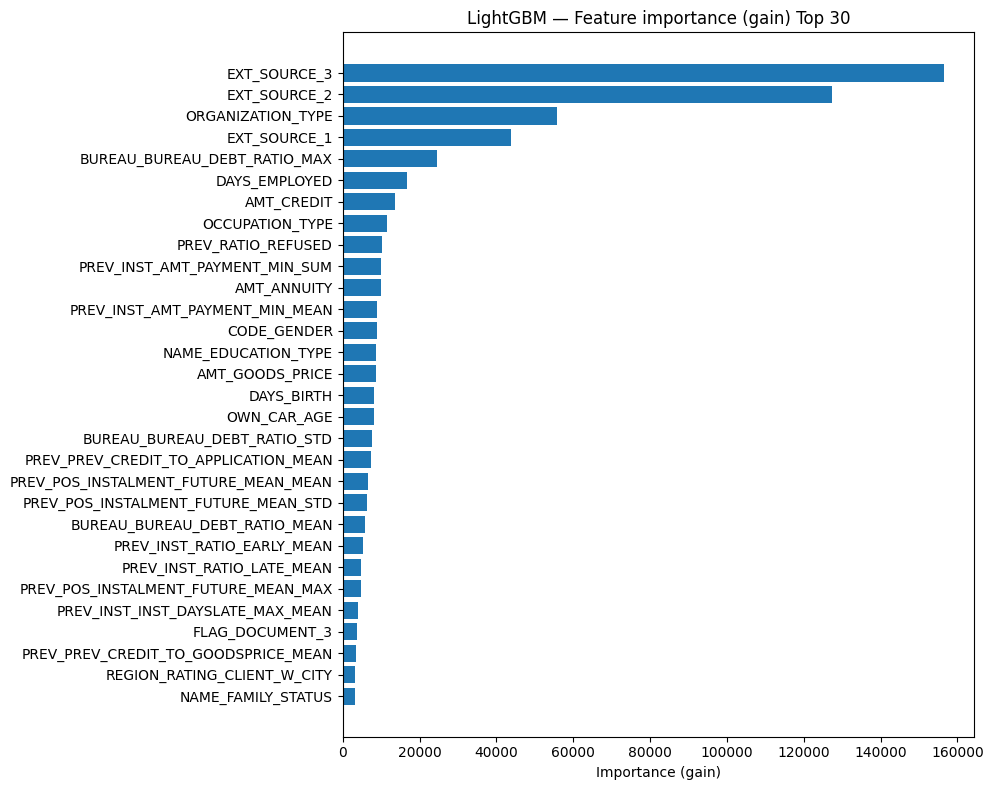

Saved: c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\reports\feature_importance\lightgbm_feature_importance_full.csv
Saved: c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\reports\feature_importance\lightgbm_feature_importance_top30.csv
PNG: c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\reports\feature_importance\lightgbm_feature_importance_top30.png


In [5]:

csv_full = REPORTS_DIR / "lightgbm_feature_importance_full.csv"
csv_top = REPORTS_DIR / f"lightgbm_feature_importance_top{TOP_N}.csv"
png_path = REPORTS_DIR / f"lightgbm_feature_importance_top{TOP_N}.png"

fi.to_csv(csv_full, index=False)
fi_top.to_csv(csv_top, index=False)

plt.figure(figsize=(10, 8))
plt.barh(fi_top["feature"][::-1], fi_top[f"importance_{importance_type}"][::-1])
plt.title(f"LightGBM — Feature importance ({importance_type}) Top {TOP_N}")
plt.xlabel(f"Importance ({importance_type})")
plt.tight_layout()
plt.savefig(png_path, dpi=150)
plt.show()

print("Saved:", csv_full)
print("Saved:", csv_top)
print("PNG:", png_path)



In [6]:

RUN_NAME = "LightGBM_feature_importance"
EXPERIMENT_NAME = "home_credit_reduction_perimetre"

summary = {
    "created_at": datetime.now().isoformat(timespec="seconds"),
    "experiment": EXPERIMENT_NAME,
    "run_name": RUN_NAME,
    "dataset": "train_split.csv",
    "n_rows": int(X_lgb.shape[0]),
    "n_features_total": int(X_lgb.shape[1]),
    "top_n": int(TOP_N),
    "importance_type": importance_type,
    "params_lgb": params_lgb,
    "artifacts": {
        "fi_full_csv": str(csv_full),
        "fi_top_csv": str(csv_top),
        "fi_top_png": str(png_path),
    },
}

summary_path = REPORTS_DIR / "lightgbm_feature_importance_summary.json"
with open(summary_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, ensure_ascii=False, indent=2)

print("Summary JSON:", summary_path)

Summary JSON: c:\Users\yoann\Documents\open classrooms\projet 8\livrables\pret a dépenser\reports\feature_importance\lightgbm_feature_importance_summary.json


## Log MLFLOW

In [7]:
with mlflow.start_run(run_name=RUN_NAME):
    mlflow.set_tag("phase", "feature_importance")
    mlflow.set_tag("model_name", "LightGBM")
    mlflow.set_tag("dataset", "train_split")
    mlflow.set_tag("importance_type", importance_type)
    mlflow.set_tag("top_n", int(TOP_N))

    mlflow.log_params(params_lgb)

    # infos dataset (utile mais léger)
    mlflow.log_metric("n_rows", int(X_lgb.shape[0]))
    mlflow.log_metric("n_features_total", int(X_lgb.shape[1]))

    # artifacts
    mlflow.log_artifact(str(csv_full))
    mlflow.log_artifact(str(csv_top))
    mlflow.log_artifact(str(png_path))
    mlflow.log_artifact(str(summary_path))

print("Run MLflow créé + artifacts loggés")

Run MLflow créé + artifacts loggés


## Analyse de l’importance des variables (LightGBM)

L’analyse des importances globales met en évidence le rôle central de quatre grandes familles de variables dans la prédiction du risque de défaut.

Les **scores externes de crédit** (EXT_SOURCE_1, 2 et 3) dominent largement le classement et constituent les indicateurs les plus informatifs du modèle.

L’**historique de crédit et de remboursement** joue également un rôle majeur, à travers des variables issues des tables Bureau et Previous Applications (ratios d’endettement, refus de crédit, montants et régularité des paiements).

Des variables liées au **profil socio-professionnel** (type d’organisation, profession, niveau d’éducation, ancienneté, âge) contribuent de façon significative, reflétant la stabilité du client.

Enfin, les **montants financiers du prêt** (montant du crédit, annuité, prix du bien) complètent les facteurs explicatifs.

Dans l’ensemble, la hiérarchie des variables est cohérente avec les pratiques métiers du scoring bancaire et fournit une base solide pour la **réduction du périmètre de features** et l’optimisation du modèle.